In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import matplotlib.patches as patches

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import os
import json
import time
from io import StringIO
from datetime import datetime
import re
import math
import pyaml

from sklearn.linear_model import LinearRegression
from scipy import integrate
from scipy.signal import find_peaks

import sys
sys.path.append("/Users/dteng/Documents/bin/nmr_utils/")
from nmr_targeted_utils import *
from nmr_fitting_funcs import *



In [2]:
# ===== params =====
template_path = "/Users/dteng/Documents/zdata/nmr/nmr_std_data/indiv_std_lproline/lproline_ph3.csv"
#template_path = "/Users/dteng/Documents/bin/nmr_constants/cal_data_pro/pro_stds/pro_std_03_r1.csv"
#path_samples = "/Users/dteng/Documents/zdata/nmr/J202208B_pro_survey/training_set_csvs/"
path_samples = "/Users/dteng/Documents/zdata/nmr/J202208B_pro_survey/all_fid_data_csvs/"
bs_grad_path = "/Users/dteng/Documents/nmr_targeted/mlgrad/results/bootstrap_results.csv"
matching_path = "/Users/dteng/Documents/zdata/nmr/nmr_std_data/lr_matching_coords/lproline_ph3_matching_regions.csv"
#template_path = "/Users/dteng/Documents/bin/nmr_constants/cal_data_pro/pro_stds/pro_std_03_r1.csv"


# diff mcoords for neat-pro-std or pro_std_03
if "pro_std_03" in template_path:
    multiplets_ls = [[1.9,2.15], [2.304, 2.408],[3.25, 3.5],[4.1, 4.2]]
if "lproline_ph3" in template_path:
    multiplets_ls = [[1.9,2.15], [2.295, 2.403], [3.25, 3.5],[4.1, 4.2]]

#signal_free_coords = [-1, 10] # signal free region is outside of these coords

normxcorr_th = 0.0 # set to this number to filter out multiplets which aren't at least normxcorr_th, i.e. poor fits
ref_pk_window = [-0.02, 0.02]
ref_pk_tolerance_window = [0,0]
search_region_padding_size = 0.02

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
folder_name = f"./results/mlgrad-pred-batch-{timestamp}"

matching_regions_ls = [
    [2.305, 2.306],
    [2.31, 2.316],
    [2.321, 2.3225],
    [2.331, 2.333],
    [2.342, 2.3445],
    [2.347, 2.349],
    [2.3585, 2.3605],
    [2.365, 2.3675],
    [2.3755, 2.3765],
    [2.381, 2.39]]

In [3]:
# ========== load data ==========
# load STD template(s)
template_df = pd.read_csv(template_path)
template_df = adjust_to_ref_peak(template_df, ref_pk_window, ref_pk_tolerance_window)

# load sample (training) data - only QCs and Rs
df_dict = {}
afid_subset_ls = ["AF62175", "AF62172", "AF62125", "AF62146", 
                  "AF11116_Q2", "AF11116_R2", "AF61767", "AF62079",
                  "AF62330", "AF62485"
                 ]
for fn in os.listdir(path_samples):
    if (".csv" in fn) and (fn.replace(".csv", "") in afid_subset_ls):
        k = fn.replace(".csv", "")
        df_dict[k] = pd.read_csv(os.path.join(path_samples, fn))

#d_matching = pd.read_csv(matching_path)

# get reds and blues
red_dt = template_df.copy()
red_dt = red_dt.loc[(red_dt["ppm"]>min(multiplets_ls[1])) & (red_dt["ppm"]<max(multiplets_ls[1]))]


In [6]:
# ===== run 1d_std_search =====
results_dict = {}
for k in sorted(list(df_dict.keys())):
    target_df = df_dict[k]
    results_dict[k] = do_1d_std_search(
        query_df=template_df,
        target_df=target_df,
        multiplets_ls=multiplets_ls,
        search_region_padding_size=search_region_padding_size
    )

# ===== get corr_series_dict =====
# get corr_series for each k, stored in corr_series_dict
blue_m1_dict = get_blue_m1_dict(results_dict, 
                                df_dict,
                                mcoords=multiplets_ls[1]
                               )

corr_series_dict = {}
for k in sorted(list(results_dict.keys())):
    dt = get_correlation_series(red_dt, 
                                     blue_m1_dict[k].copy(),
                                     min_corr=0, 
                                     min_corr_replacement_value=0,
                                     window_size_nrows=64
                                    )
    # take square of corr_series
    temp_ls = np.square(dt["corr_series"].values)
    dt["corr_series"] = temp_ls
    corr_series_dict[k] = dt

# ===== run LR matching =====
df_conc = get_df_conc_lrmatching(
    results_dict=results_dict, 
    template_df=template_df.copy(), 
    df_dict=df_dict, 
    mcoords=multiplets_ls[1],
    matching_coords_ls=matching_regions_ls,
    corr_series_dict=corr_series_dict
)


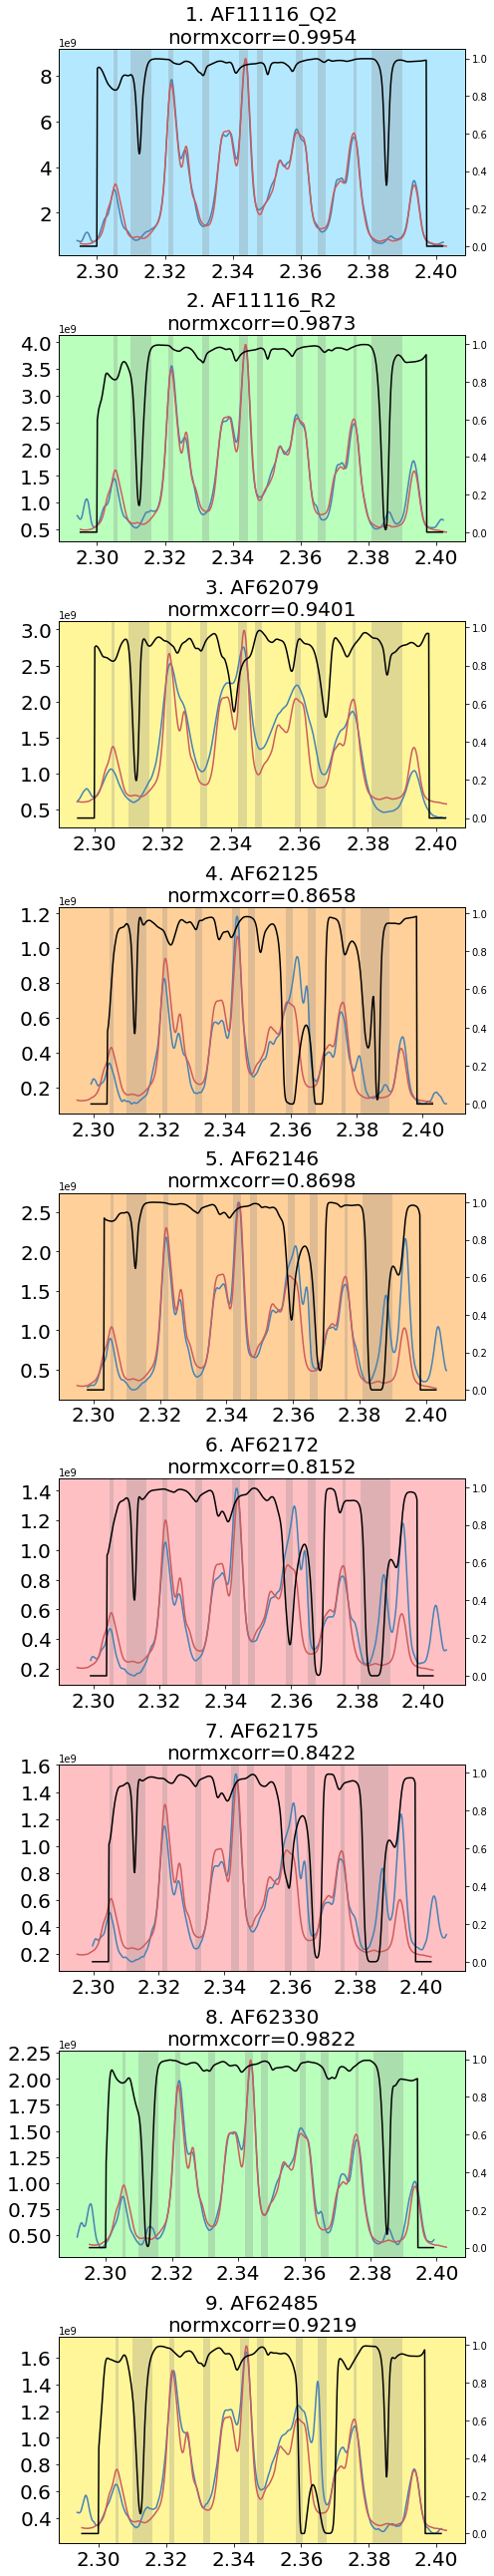

In [7]:
# ===== plot match results =====
fig, ax = plt.subplots(nrows=len(results_dict), # top row for LR results
                       ncols=1, 
                       figsize=(7, len(results_dict)*4)
                      )

red_dt = template_df.copy()
red_dt = red_dt.loc[(red_dt["ppm"]>min(multiplets_ls[1])) & (red_dt["ppm"]<max(multiplets_ls[1]))]

i = 0
for k in sorted(list(results_dict.keys())):
    # plot fit
    normxcorr = results_dict[k]["multiplet_1"]["max_rho"][0]
    ax[i].plot(blue_m1_dict[k].ppm.values, 
               blue_m1_dict[k].intensity.values, c="steelblue")

    m = df_conc.loc[df_conc["sample_name"]==k]["slope"].values[0]
    c = df_conc.loc[df_conc["sample_name"]==k]["intercept"].values[0]
    ax[i].plot(red_dt.ppm.values, 
               (red_dt.intensity.values*m)+c, 
               c="indianred")

    ax[i].set_title(f"{i+1}. {k}\nnormxcorr={round(normxcorr, 4)}", fontsize=20)
    
    # plot sliding window of correlation
    ax2 = ax[i].twinx()
    ax2.plot(corr_series_dict[k]["ppm"], 
             corr_series_dict[k]["corr_series"], 
             c="k")
    
    # set bg colour
    transparency = 0.65
    bg_colour = (1, 159/255, 165/255, transparency) # red
    if normxcorr >= 0.85 and normxcorr < 0.9:
        bg_colour = (1, 184/255, 100/255, transparency) # orange
    if normxcorr >= 0.9 and normxcorr < 0.95:
        bg_colour = (1, 242/255, 100/255, transparency) # yellow     
    if normxcorr >= 0.95 and normxcorr < 0.99:
        bg_colour = (150/255, 1, 153/255, transparency) # green
    elif normxcorr >= 0.99:
        bg_colour = (140/255, 220/255, 1, transparency) # light blue
    ax[i].set_facecolor(bg_colour)
    plt.setp(ax[i].get_xticklabels(), fontsize=20)
    plt.setp(ax[i].get_yticklabels(), fontsize=20)
    
    # draw matching regions
    rect_height = ax[i].get_ylim()[1]
    for row in matching_regions_ls:
        #ax[i].axvline(row[0], lw=0.5, c="k")
        #ax[i].axvline(row[1], lw=0.5, c="k")
        
        # Create a rectangle patch
        rect = patches.Rectangle((min(row), 0), 
                                 max(row) - min(row), 
                                 rect_height, 
                                 edgecolor=None,
                                 facecolor='grey', 
                                 alpha=0.25)

        # Add the rectangle patch to the plot
        ax[i].add_patch(rect)

    i += 1

plt.subplots_adjust(hspace=0.2, wspace=0)
plt.tight_layout()

#plt.savefig("test.png", dpi=300)
plt.show()

# Peak/Trough Matching

In [ ]:
k = "AF62079"
red_pks = get_peaks_and_troughs(red_dt)
blue_pks = get_peaks_and_troughs(blue_m1_dict[k].copy())

d_matching_features = get_matching_features(
    red_pks,
    blue_pks
)

# do LR for canonical features
model = LinearRegression()
model.fit(d_matching_features["intensity_red"].values.reshape(-1, 1), 
          d_matching_features["intensity_blue"].values
         )

intercept = model.intercept_
slope = model.coef_[0]

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(red_dt.ppm.values, 
         red_dt.intensity.values*slope+intercept, 
         c="indianred")
plt.scatter(red_pks.ppm.values, 
            red_pks.intensity.values*slope+intercept, 
            c="indianred")

plt.plot(blue_m1_dict[k].ppm.values, 
         blue_m1_dict[k].intensity.values, 
         c="steelblue")
plt.scatter(blue_pks.ppm.values, 
            blue_pks.intensity.values, 
            c="steelblue")

for idx, row in d_matching_features.iterrows():
    plt.axvline(float(row["ppm_red"]), c="indianred", lw=0.5)
    plt.axvline(float(row["ppm_blue"]), c="steelblue", lw=0.5)